In [2]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import lxml
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../files/df_a_usar_2.csv', index_col=0)
df.sample(3)

,index,time,age,gender,country_q3,education_q4,role_q5,experience_q6,Q8,Q11,...,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
24809,24809,593,25-29,Man,Chile,Master’s degree,Student,< 1 years,R,A laptop,...,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5847,5847,626,30-34,Man,Peru,Master’s degree,Business Analyst,< 1 years,SQL,A laptop,...,NaN,Sacred + Omniboard,TensorBoard,NaN,Polyaxon,NaN,NaN,NaN,NaN,NaN
18837,18837,295,22-24,Man,India,Bachelor’s degree,Student,1-3 years,Python,A personal computer / desktop,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
gender = (df['gender'].value_counts()).reset_index()
gender

,index,gender
0,Man,20598
1,Woman,4890
2,Prefer not to say,355
3,Nonbinary,88
4,Prefer to self-describe,42


In [5]:
gender['index']

0                        Man
1                      Woman
2          Prefer not to say
3                  Nonbinary
4    Prefer to self-describe
Name: index, dtype: object

In [6]:
puestos = df['role_q5'].value_counts()
#puestos.sort_values(ascending=False)
puestos

Student                         6804
Data Scientist                  3616
Software Engineer               2449
Other                           2393
Data Analyst                    2301
Currently not employed          1986
Research Scientist              1538
Machine Learning Engineer       1499
Business Analyst                 968
Program/Project Manager          849
Data Engineer                    668
Product Manager                  319
Statistician                     313
DBA/Database Engineer            171
Developer Relations/Advocacy      99
Name: role_q5, dtype: int64

#### Depuración de la categoría 'gender':

Observamos 5 categorías, siendo 2 hombre y mujer (géneros binarios), estando las 3 restantes dedicadas a aquellas personas que no se encuentran en el marco binario del género o prefieren no reportar su identidad de género.

Tras consultar a la comunidad científica, [como es el caso de esta guía orientada a la investigación HCI (Human-Computer Interaction (2019)](https://sci-hub.hkvisa.net/10.1145/3338283), optamos por fusionar las categorías 'Nonbinary' y 'Prefer to self-describe'.

In [17]:
df['gender2'] = df['gender'].replace({'Man': 'Man', 'Woman': 'Woman', 'Prefer to self-describe': 'NB', 'Nonbinary': 'NB', 'Prefer not to say': np.nan})
df['gender2'].value_counts()

Man      20598
Woman     4890
NB         130
Name: gender2, dtype: int64

In [21]:
df.isnull().sum()

index                0
time                 0
age                  0
gender               0
country_q3           0
                 ...  
Q38_B_Part_9     25307
Q38_B_Part_10    23226
Q38_B_Part_11    21431
Q38_B_OTHER      25596
gender2            355
Length: 243, dtype: int64

In [19]:
df['gender2'].dropna(how='any', inplace=True)

In [20]:
df['gender2'].isnull().sum()

355

#### Depuración de la categoría 'puesto':


In [11]:
spain = df[df['country_q3'] == 'Spain']
spain['gender2'].value_counts()

Hombre    389
Mujer      57
NB          2
Name: gender2, dtype: int64

#### Tabla de contingencias

Género x Puesto

In [ ]:
tab_conting = pd.crosstab(df['role_q5'], df['gender2'], margins=False)
tab_conting

gender2,Hombre,Mujer,NB
role_q5,,,
Business Analyst,779,175,4
Currently not employed,1479,463,15
DBA/Database Engineer,141,20,1
Data Analyst,1759,505,9
Data Engineer,561,98,2
Data Scientist,2971,584,16
Developer Relations/Advocacy,79,16,2
Machine Learning Engineer,1285,179,10
Other,1926,429,12


Cálculo de las frecuencias relativas con % verticales (distribución por género):

In [ ]:
#https://stackoverflow.com/a/21247312
per_tab_conting = pd.crosstab(df['role_q5'], df['gender2'], margins=False).apply(lambda x: round(x/x.sum(), 2), axis=0)
per_tab_conting

gender2,Hombre,Mujer,NB
role_q5,,,
Business Analyst,0.04,0.04,0.03
Currently not employed,0.07,0.09,0.12
DBA/Database Engineer,0.01,0.00,0.01
Data Analyst,0.09,0.10,0.07
Data Engineer,0.03,0.02,0.02
Data Scientist,0.14,0.12,0.12
Developer Relations/Advocacy,0.00,0.00,0.02
Machine Learning Engineer,0.06,0.04,0.08
Other,0.09,0.09,0.09


#### **Interpretación inicial de las frecuencias relativas**:

Se optan por los porcentajes de columna dado que los hombres cuadriplican a las mujeres, distorsionando los resultados de los % de género por cada puesto. En los próximos pasos de la investigación, sería necesario ponderar los casos.


- En la muestra predominan lxs estudiantes: Más de un cuarto de las mujeres de la muestra (32%) son estudiantes, seguidas de las personas no binarias (28%) y hombres (25%).

- Entre las categorías más frecuentes, independientemente del género, se encuentra el rol de Data Scientist: El 14% de los hombres desempeñan este rol, y en el caso de las mujeres y personas NB un 12%.

- Existen también diferencias según el género:
    - El 10% de los hombres desempeñan el rol de ingenieros de software, frente al 7% de mujeres y 6% de personas NB.
    - El 10% de las mujeres son analistas de datos, frente al 9% de hombres y 7% de personas NB.
    - El 12% de las personas NB encuestadas están actualmente en situación de desempleo.

In [ ]:
tab_conting.corr()


gender2,Hombre,Mujer,NB
gender2,,,
Hombre,1.000000,0.965892,0.956768
Mujer,0.965892,1.000000,0.970238
NB,0.956768,0.970238,1.000000


### **Representaciones gráficas:**

#### - Género:

In [ ]:
gender2 = (df['gender2'].value_counts()).reset_index()
gender2

,index,gender2
0,Hombre,20598
1,Mujer,4890
2,NB,130


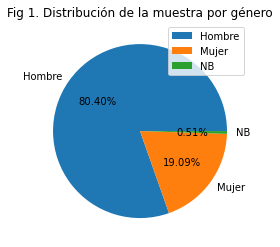

In [ ]:
plt.figure()
plt.pie(gender2['gender2'], labels=gender2['index'], autopct='%1.2f%%')
plt.legend(gender2['index'])
plt.title('Fig 1. Distribución de la muestra por género')
plt.show();

#### - Puesto:

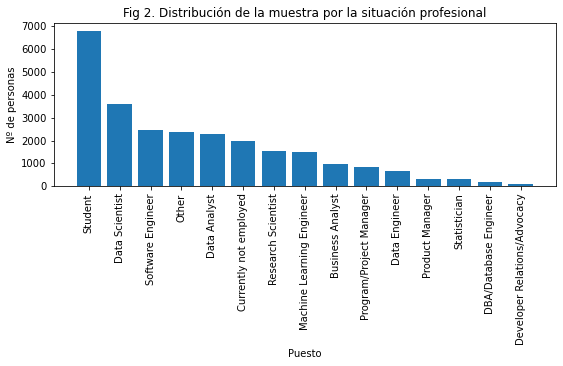

In [ ]:
plt.figure(figsize=(9,3))

#representación gráfica
plt.bar(puestos.index, puestos.values)

#etiquetas:
plt.xlabel('Puesto')
plt.ylabel('Nº de personas')
plt.xticks(rotation=90)

plt.title('Fig 2. Distribución de la muestra por la situación profesional')

plt.show();

#### - Representación gráfica de la distribución de la muestra según el género y el puesto:

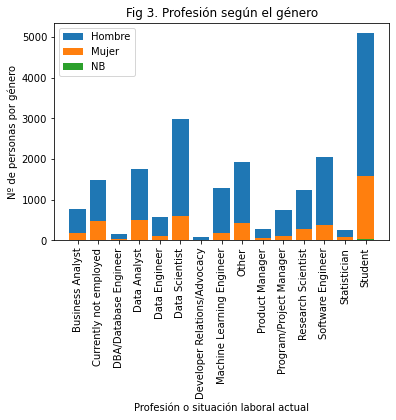

In [ ]:
plt.figure()

#representación gráfica
plt.bar(tab_conting['Hombre'].index, tab_conting['Hombre'].values)
plt.bar(tab_conting['Mujer'].index, tab_conting['Mujer'].values)
plt.bar(tab_conting['NB'].index, tab_conting['NB'].values)

#etiquetas
plt.xticks(rotation=90)
plt.legend(tab_conting.columns)
plt.title('Fig 3. Profesión según el género')
plt.xlabel('Profesión o situación laboral actual')
plt.ylabel('Nº de personas por género')

plt.show();

#### Aproximación a la correlación entre género y puesto:

#### Cálculo de la correlación:

Vamos a calcular la correlación entre género y puesto. Para ello haremos las siguientes operaciones:
- Chi cuadrado (al tratarse de dos variables categóricas)
- Cálculo de residuos para comprobar en qué género(s) existe una relación con el puesto.

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
#https://thinkingneuron.com/how-to-measure-the-correlation-between-two-categorical-variables-in-python/
chi2 = chi2_contingency(tab_conting)
if chi2[1] <= .05:
    print(f"Existen diferencias significativas en el tipo de puesto según el género, con una p de {round(chi2[1], 2)}")
else:
    print(f"No existen diferencias significativas en el tipo de puesto según el género, con una p de {round(chi2[1], 2)}")

Existen diferencias significativas en el tipo de puesto según el género, con una p de 0.0
